# 3. Google's PageRank
PageRank was originally invented by Google in 1998 and had became an extraordinary success as a search engine. It makes clever use of *eigenvalues* and *eigenvectors* to rank websites, thus delivers the most relevant result for the search query. The algorithm works in a *linked database*, where each node may contain some kind of *links* or *references* to other nodes. Two most familiar *linked databases* appear in real life are (1) research papers containing *citations* and (2) the world wide web, where web pages contain *links* to others.

The advantage of recommendation engines generated by PageRank is that they ensure the more backlinks a page has, the more reliable it is. They also place more influence to a link from a trustworthy page compared to links from a less reliable page.

*Reference:*
- *[Google Patents - Method for node ranking in a linked database](https://patentimages.storage.googleapis.com/37/a9/18/d7c46ea42c4b05/US6285999.pdf) (original version)*
- *[Google Patents - Producing a ranking for pages using distances in a web-link graph](https://patentimages.storage.googleapis.com/b8/dc/3e/3b5b32f8acd264/US9165040.pdf) (updated version)*

## 3.1. The algorithm

In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

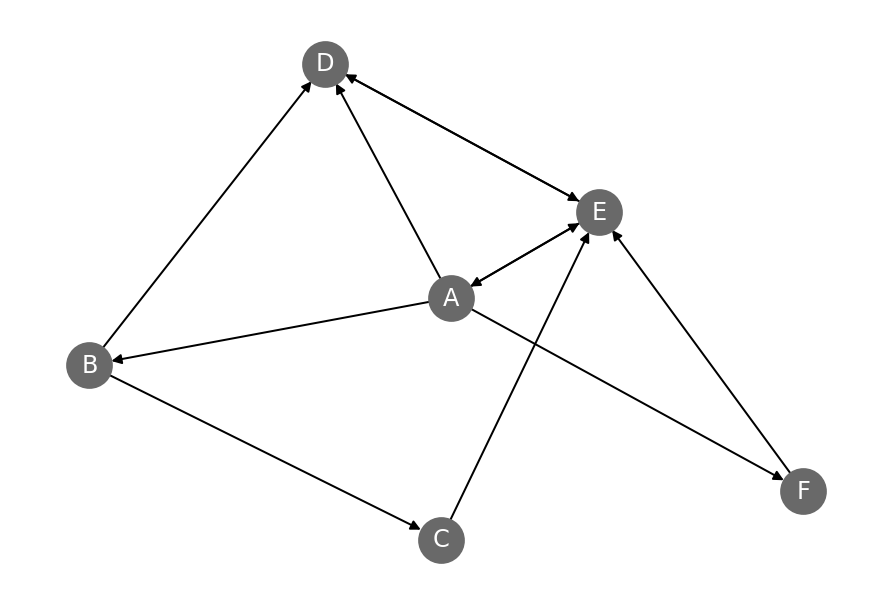

In [8]:
G = nx.DiGraph()
G.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F'])
G.add_edges_from([
    ('A', 'B'), ('A', 'D'), ('A', 'E'), ('A', 'F'),
    ('B', 'C'), ('B', 'D'),
    ('C', 'E'),
    ('D', 'E'),
    ('E', 'A'), ('E', 'D'),
    ('F', 'E')
])
pos = pos=nx.spring_layout(G, seed=19)
nx.draw(G, node_color='dimgrey', font_color='w', with_labels=True, node_size=500, pos=pos)

### Simplified algorithm
Let's say there are a total of $n$ pages in the web. Consider a page $P$, it has $k$ backlink pages denoted $B_1,B_2,\dots,B_k$ and their associated number of foward links are $l(B_1),l(B_2),\dots,l(B_k)$. In a simple ranking system, the rank of page $P$ is simply $r(P)=k$; however this method gives equal weight to all links, despite the fact that some links can come from pages having more influence. To address this problem, rank of $P$ is defined as:

$$r(P)=\frac{r(B_1)}{l(B_1)}+\frac{r(B_2)}{l(B_2)}+\dots+\frac{r(B_k)}{l(B_k)}$$

Doing this for all $n$ pages ends up getting a system of linear equations, and solving this results in the rank value of each page. Altenatively, this can also be done using some Linear Algebra. First, create an [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix) $\mathbf{A}\;(n\times n)$ and a vector of ranks $\mathbf{r}\;(n\times1)$:

$$
\mathbf{A}=\begin{bmatrix}
0 & 0 & 0 & 0 & \frac{1}{2} & 0 \\
\frac{1}{4} & 0 & 0 & 0 & 0 & 0 \\
0 & \frac{1}{2} & 0 & 0 & 0 & 0 \\
\frac{1}{4} & \frac{1}{2} & 0 & 0 & \frac{1}{2} & 0 \\
\frac{1}{4} & 0 & 1 & 1 & 0 & 1 \\
\frac{1}{4} & 0 & 0 & 0 & 0 & 0
\end{bmatrix}\;\quad
\mathbf{r}=\begin{bmatrix}
r(A) \\ r(B) \\ r(C) \\ r(D) \\ r(E) \\ r(F)
\end{bmatrix}
$$

The final goal is to find $\mathbf{r}$ that satisfies the equation: $\mathbf{Ar}=\mathbf{r}$. In the adjacency matrix, the entry $\mathbf{A}_{ij}$ represents the probability that a surfer will jump from page $P_i$ to page $P_j$. Thus, each column of $\mathbf{A}$ is a [probability vector](https://en.wikipedia.org/wiki/Probability_vector) describes how a page distributes its value to forward links, has the values sum up to $1$. Such a matrix is called an [stochastic matrix](https://en.wikipedia.org/wiki/Stochastic_matrix), which always has $\lambda=1$ as the *dominant eigenvalue* (the eigenvalue having the greatest absolute value). This is a very important properties of $\mathbf{A}$, proving why $\mathbf{r}$ is an eigenvector of $\mathbf{A}$:

$$\mathbf{Ar}=\lambda\mathbf{r}$$

In [9]:
A = np.array([
    [   0,   0,   0,   0, 0.5,   0],
    [0.25,   0,   0,   0,   0,   0],
    [   0, 0.5,   0,   0,   0,   0],
    [0.25, 0.5,   0,   0, 0.5,   0],
    [0.25,   0,   1,   1,   0,   1],
    [0.25,   0,   0,   0,   0,   0]
])

eigenvalues, eigenvectors = np.linalg.eig(A)

In [10]:
eigenvalues

array([ 1.00000000e+00+0.00000000e+00j, -1.39845075e-01+3.92402580e-01j,
       -1.39845075e-01-3.92402580e-01j, -7.20309850e-01+0.00000000e+00j,
       -1.42918584e-17+2.84379544e-17j, -1.42918584e-17-2.84379544e-17j])

In [11]:
r = eigenvectors[:, 0]
r = np.real(r)
r = r / r.sum()
r

array([0.2  , 0.05 , 0.025, 0.275, 0.4  , 0.05 ])

### Damping factor
The PageRank theory holds that a web surfer will sometimes jump to a random page after following a number of foward links. Denote $\alpha$ for the probability that the surfer continues clicking on foward links, then $1-\alpha$ is called the *damping factor*. Various studies have tested $\alpha$, and concluded that the value of this parameter is around $0.85$. The rank of $P$ is given by the formula:

$$r(P)=\frac{1-\alpha}{n}+\alpha\sum{\frac{r(B_i)}{l(B_i)}}$$

Let $\displaystyle{d=\frac{1-\alpha}{n}}$. Since $\mathbf{r}$ is a probability vector, it has the following property:

$$
\begin{bmatrix}
d & d & d & d & d & d \\
d & d & d & d & d & d \\
d & d & d & d & d & d \\
d & d & d & d & d & d \\
d & d & d & d & d & d \\
d & d & d & d & d & d \\
\end{bmatrix}
\begin{bmatrix}
r(A) \\ r(B) \\ r(C) \\ r(D) \\ r(E) \\ r(F) \\
\end{bmatrix}=
\begin{bmatrix}
d \\ d \\ d \\ d \\ d \\ d
\end{bmatrix}
$$

With the appearance of damping factor, the equation of the problem is:

$$\begin{alignat*}{2}
& \qquad          & \mathbf{d}+\alpha\mathbf{Ar}              & =\mathbf{r} \\
& \Leftrightarrow & \mathbf{dr}+\alpha\mathbf{Ar}             & =\mathbf{r} \\
& \Leftrightarrow & (\mathbf{d}+\alpha\mathbf{A})\,\mathbf{r} & =\mathbf{r} \\
\end{alignat*}$$

Observing the matrix $\mathbf{A'}=\mathbf{d}+\alpha\mathbf{A}$, the sum of elements in each of its column is $dn+\alpha=1$, thus this matrix is also a *stochastic matrix*. For this reason, $\mathbf{r}$ in this case is the eigenvector corresponding to the *domiant eigenvalue* of $\mathbf{A'}$.

In [12]:
A = np.array([
    [   0,   0,   0,   0, 0.5,   0],
    [0.25,   0,   0,   0,   0,   0],
    [   0, 0.5,   0,   0,   0,   0],
    [0.25, 0.5,   0,   0, 0.5,   0],
    [0.25,   0,   1,   1,   0,   1],
    [0.25,   0,   0,   0,   0,   0]
])

n = A.shape[0]
alpha = 0.4
d = (1-alpha)/n

M = d + alpha*A

eigenvalues, eigenvectors = np.linalg.eig(M)
eigenvalues

array([ 1.00000000e+00+0.j        , -5.59380299e-02+0.15696103j,
       -5.59380299e-02-0.15696103j, -2.88123940e-01+0.j        ,
       -1.49047485e-17+0.j        , -3.88427380e-17+0.j        ])

In [13]:
r = eigenvectors[:, 0]
r = np.real(r)
r = r / r.sum()
r

array([0.15803815, 0.11580381, 0.12316076, 0.19700272, 0.29019074,
       0.11580381])

### Power method
In practice, there is millions of documents in a system and it is not possible to calculate the eigenvector algebraically. Accordingly, a method for estimating the dominant eigenvector called the [power iteration](https://en.wikipedia.org/wiki/Power_iteration) is used. This method initializes each entry in the vector $\mathbf{r_0}$ to be equal, then keep multiply the matrix $\mathbf{A}$ to $\mathbf{r}$. This iteration process will converge to a steady state, where the result is the domnant eigenvector of $\mathbf{A}$:

$$\mathbf{r}=\lim_{p\rightarrow\infty}\mathbf{A}^p\,\mathbf{r_0}$$

Many implementations have pointed out that the convergence is very fast, it takes about $100$ iterations in case of millions of pages, which is much less expensive than calculating the eigenvalue directly. In the 6-page example above, only 7 iterations is needed.

In [14]:
A = np.array([
    [   0,   0,   0,   0, 0.5,   0],
    [0.25,   0,   0,   0,   0,   0],
    [   0, 0.5,   0,   0,   0,   0],
    [0.25, 0.5,   0,   0, 0.5,   0],
    [0.25,   0,   1,   1,   0,   1],
    [0.25,   0,   0,   0,   0,   0]
])

n = A.shape[0]
alpha = 0.4
d = (1-alpha)/n

M = d + alpha*A


r = np.ones([6,1]) / n
r = np.linalg.matrix_power(M, 7) @ r
r = r / r.sum()
r

array([[0.158032  ],
       [0.115806  ],
       [0.12315947],
       [0.19699747],
       [0.29019907],
       [0.115806  ]])

## 3.2. Implementation
This sections introduces using the
<code style='font-size:13px;'><a href='https://networkx.org/documentation/stable/reference/index.html'>networkx</a></code>
library to implement the algorithm and visualize the results.

In [15]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

### Running the algorithm

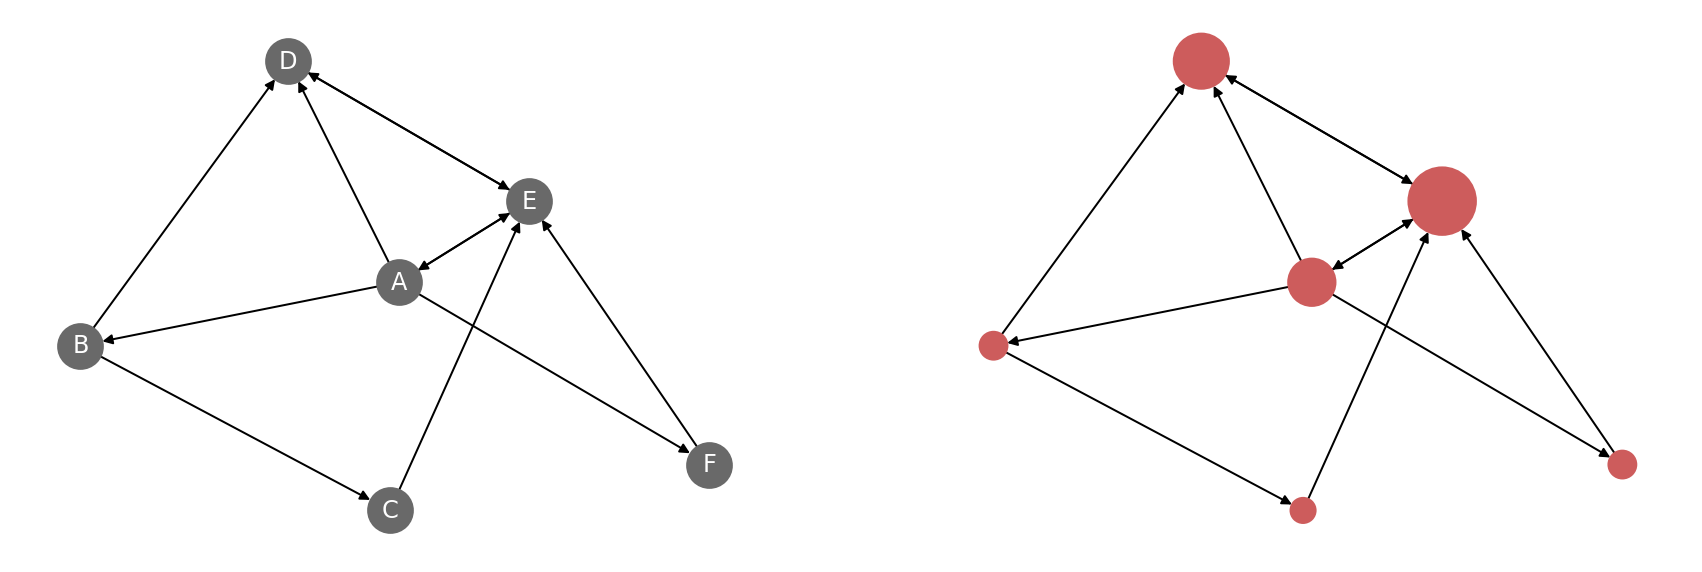

In [16]:
G = nx.DiGraph()
G.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F'])
G.add_edges_from([
    ('A', 'B'), ('A', 'D'), ('A', 'E'), ('A', 'F'),
    ('B', 'C'), ('B', 'D'),
    ('C', 'E'),
    ('D', 'E'),
    ('E', 'A'), ('E', 'D'),
    ('F', 'E')
])
pos = pos=nx.spring_layout(G, seed=19)

pr = nx.pagerank(G)
n_node = len(G.nodes)
node_sizes = list(map(lambda x: x*500*n_node, list(pr.values())))

fig, ax = plt.subplots(ncols=2, figsize=(15,5))
nx.draw(G, node_color='dimgrey', font_color='w', with_labels=True, node_size=500, pos=pos, ax=ax[0])
nx.draw(G, node_color='indianred', node_size=node_sizes, pos=pos, ax=ax[1])
plt.show()

### Adjacency matrix

In [17]:
A = nx.adjacency_matrix(G).toarray().T
A = A / A.sum(axis=0)
A

array([[0.  , 0.  , 0.  , 0.  , 0.5 , 0.  ],
       [0.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.5 , 0.  , 0.  , 0.  , 0.  ],
       [0.25, 0.5 , 0.  , 0.  , 0.5 , 0.  ],
       [0.25, 0.  , 1.  , 1.  , 0.  , 1.  ],
       [0.25, 0.  , 0.  , 0.  , 0.  , 0.  ]])

### Reading network data

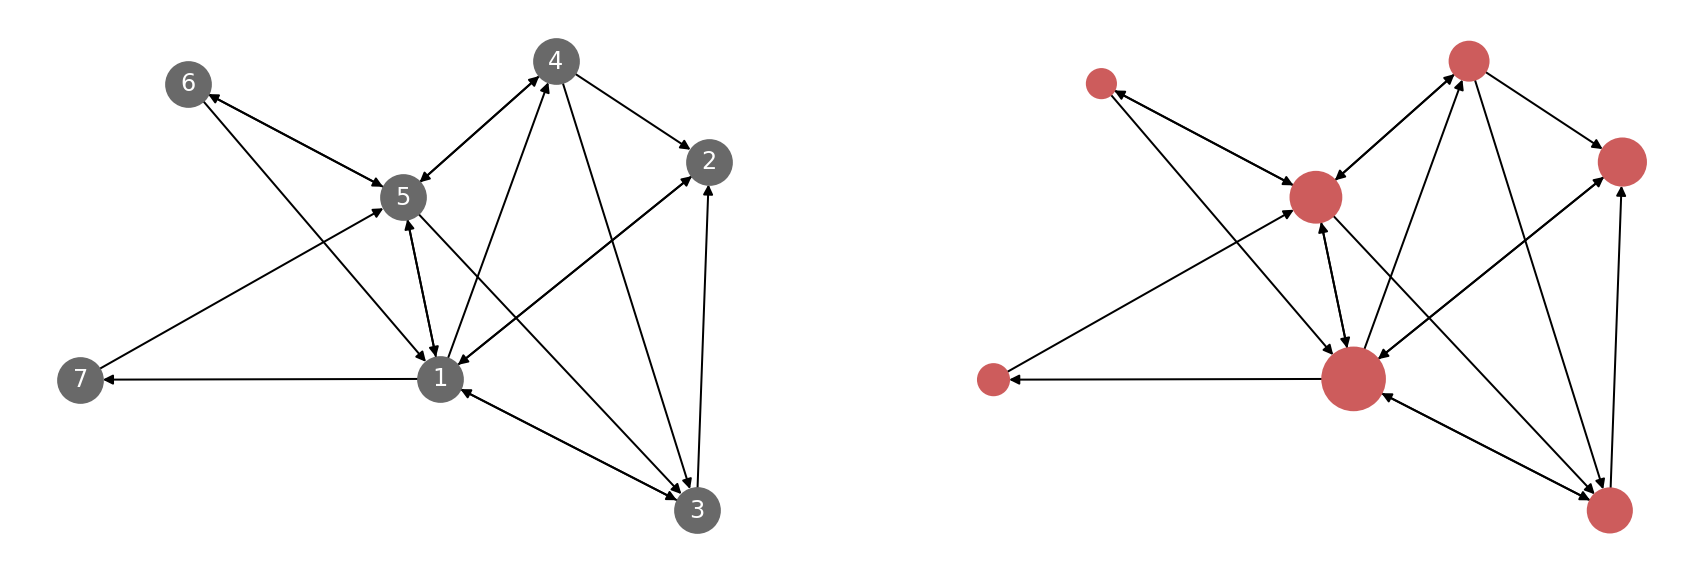

In [18]:
G = nx.read_edgelist('data/network.txt', delimiter=',', create_using=nx.DiGraph())
pos = pos=nx.spring_layout(G, seed=13)

pr = nx.pagerank(G)
n_node = len(G.nodes)
node_sizes = list(map(lambda x: x*500*n_node, list(pr.values())))

fig, ax = plt.subplots(ncols=2, figsize=(15,5))
nx.draw(G, node_color='dimgrey', font_color='w', with_labels=True, node_size=500, pos=pos, ax=ax[0])
nx.draw(G, node_color='indianred', node_size=node_sizes, pos=pos, ax=ax[1])
plt.show()

### Special graphs
Networkx supports generating [special graphs](https://networkx.org/documentation/stable/reference/generators.html).

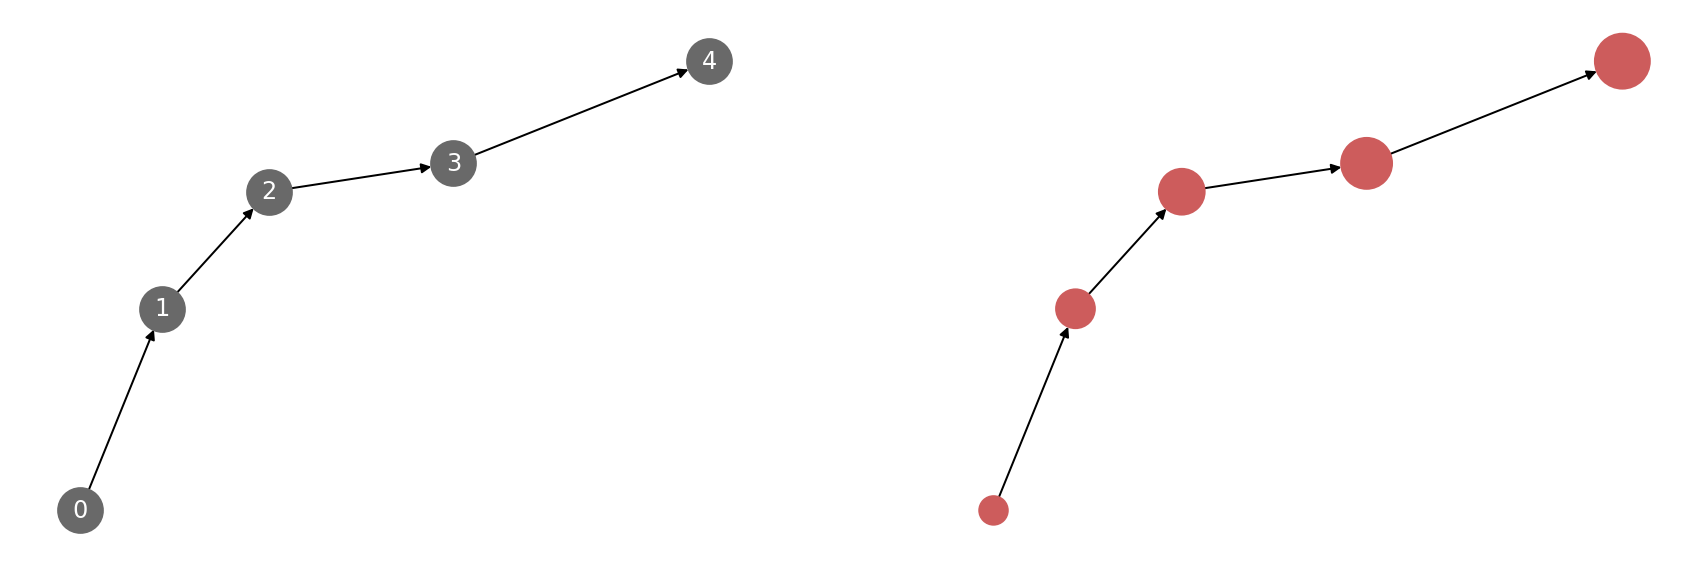

In [19]:
G = nx.path_graph(5, create_using=nx.DiGraph())
pos = pos=nx.spring_layout(G, seed=11)

pr = nx.pagerank(G)
n_node = len(G.nodes)
node_sizes = list(map(lambda x: x*500*n_node, list(pr.values())))

fig, ax = plt.subplots(ncols=2, figsize=(15,5))
nx.draw(G, node_color='dimgrey', font_color='w', with_labels=True, node_size=500, pos=pos, ax=ax[0])
nx.draw(G, node_color='indianred', node_size=node_sizes, pos=pos, ax=ax[1])
plt.show()

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*